# Building RNN, LSTM, and GRU for time series using PyTorch

In this notebook, I'd like to give you a bit of an introduction to some of the RNN structures, such as RNN, LSTM, and GRU, and help you get started building your deep learning models for time-series forecasting using PyTorch. 

Due to PyTorch's recency, it has been somewhat difficult for me to find the relevant pieces of information and code samples from the get-go, which is usually a bit easier with frameworks that have been around for a while, say TensorFlow. So, I decided to put together the things I would have liked to know earlier. 


## Installing libraries

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cpu"

## Loading the dataset

Well, I suppose we need some time-series data to start with. Be it payment transactions or stock exchange data, time-series data is everywhere. One such public dataset is [PJM's Hourly Energy Consumption data](https://www.kaggle.com/robikscube/hourly-energy-consumption), a univariate time-series dataset of 10+ years of hourly observations collected from different US regions. I'll be using the PJM East region data, which originally has the hourly energy consumption data from 2001 to 2018, but any of the datasets provided in the link should work.

The following cell pops up an upload widget, so that you can upload your data to this notebook. 

If you'd like to work with a dataset other than _PJME_hourly.csv_, you can change the field in the next cell accordingly.

In [7]:
import io
df = pd.read_csv('C:\PYTHON\PythonLab5\dataset.csv')
df.columns = ['data', 'temp_day', 'wind', 'pressure_day', 'temp_even', 'pressure_even']  # 2

nan_value = float("NaN")                             # 3  ( null / None / Nan ) 
df.replace(" ", nan_value, inplace=True)
df = df.dropna()
df[['temp_day', "temp_even"]] = df[['temp_day', "temp_even"]].astype(int) 

In [9]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
    

In [10]:
df = df.set_index(['data'])
df = df.rename(columns={'temp_day': 'value'})

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()
    
plot_dataset(df, title='PJM East (PJME) Region: estimated energy consumption in Megawatts (MW)')
    

KeyError: "None of ['data'] are in the columns"

The next step is to generate feature columns to transform our univariate dataset into a multivariate dataset. We will convert this time series into a supervised learning problem if you will. In some datasets, such features as hourly temperature, humidity, or precipitation, are readily available. However, in our dataset, no extra information could help us predict the energy consumption is given. So, it falls to our lot to create such predictors, i.e., feature columns.

I'll show you two popular ways to generate features: passing lagged observations as features and creating date time features from the DateTime index. Both approaches have their advantages and disadvantages, and each may prove more useful depending on the task at hand.

## Generating time-lagged observations

Let's start with using time steps as features. In other words, we're trying to predict the next value, _X(t+n)_, from the previous n observations _Xt, X+1, …, and X(t+n-1)_. Then, what we need to do is simply creating n columns with the preceding observations. Luckily, Pandas provides the method _shift()_ to shift the values in a column. So, we can write a for loop to create such lagged observations by shifting the values in a column by n times and removing the first n columns.

After setting the number of input features, i.e., lagged observations, to 100, we get the following DataFrame with 101 columns, one for the actual value, and the rest for the preceding 100 observations at each row.

In [ ]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
df_timelags

<ipython-input-36-9686bd7878a4>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-01-05 05:00:00,26822.0,26669.0,27034.0,27501.0,28635.0,30924.0,33202.0,35368.0,36762.0,37539.0,...,30692.0,29943.0,29595.0,29308.0,28654.0,28057.0,27899.0,28357.0,29265.0,30393.0
2002-01-05 06:00:00,27399.0,26822.0,26669.0,27034.0,27501.0,28635.0,30924.0,33202.0,35368.0,36762.0,...,31395.0,30692.0,29943.0,29595.0,29308.0,28654.0,28057.0,27899.0,28357.0,29265.0
2002-01-05 07:00:00,28557.0,27399.0,26822.0,26669.0,27034.0,27501.0,28635.0,30924.0,33202.0,35368.0,...,31496.0,31395.0,30692.0,29943.0,29595.0,29308.0,28654.0,28057.0,27899.0,28357.0
2002-01-05 08:00:00,29709.0,28557.0,27399.0,26822.0,26669.0,27034.0,27501.0,28635.0,30924.0,33202.0,...,31031.0,31496.0,31395.0,30692.0,29943.0,29595.0,29308.0,28654.0,28057.0,27899.0
2002-01-05 09:00:00,31241.0,29709.0,28557.0,27399.0,26822.0,26669.0,27034.0,27501.0,28635.0,30924.0,...,30360.0,31031.0,31496.0,31395.0,30692.0,29943.0,29595.0,29308.0,28654.0,28057.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,45641.0,46760.0,46816.0,46989.0,47154.0,46534.0,45372.0,43954.0,42189.0,...,28389.0,30789.0,33747.0,36581.0,37870.0,39089.0,40517.0,40709.0,39906.0,38637.0
2018-08-02 21:00:00,43256.0,44057.0,45641.0,46760.0,46816.0,46989.0,47154.0,46534.0,45372.0,43954.0,...,26779.0,28389.0,30789.0,33747.0,36581.0,37870.0,39089.0,40517.0,40709.0,39906.0
2018-08-02 22:00:00,41552.0,43256.0,44057.0,45641.0,46760.0,46816.0,46989.0,47154.0,46534.0,45372.0,...,25675.0,26779.0,28389.0,30789.0,33747.0,36581.0,37870.0,39089.0,40517.0,40709.0


## Splitting the data into test, validation, and train sets

After creating feature columns, be it time-lagged observations or date/time features, we split the dataset into three different datasets: training, validation, and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'value', 0.2)

### Applying scale transformation

Scaling the values in your dataset is a highly recommended practice for neural networks, as it is for other machine learning techniques. It speeds up the learning by making it easier for the model to update the weights. You can easily do that by using Scikit-learn's scalers, MinMaxScaler, RobustScaler, StandardScaler, and the like. For more information on the effects of each scaler, please refer to the official documentation.

And, here is a cool trick if you're looking for a way to switch between scalers quickly. Get yourself comfortable with the switcher function; we may use it again later on.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

### Loading the data into DataLoaders

After you standardize your data, you are usually good to go. Not so fast, this time. After spending quite some time working with PyTorch and going through others' code on the internet, I noticed most people ended up doing the matrix operations for mini-batch training, i.e., slicing the data into smaller batches, using NumPy. You may think that's what NumPy is for; I get it. But there is also a more elegant PyTorch way of doing it, which certainly gets much less attention than it should, in my opinion.

PyTorch's DataLoader class, a Python iterable over Dataset, loads the data and splits them into batches for you to do mini-batch training. The most important argument for the DataLoader constructor is the Dataset, which indicates a dataset object to load data from. There are mainly two types of datasets, one being map-style datasets and the other iterable-style datasets. 

In this tutorial, I'll use the latter, but feel free to check them out in [the official documentation](https://pytorch.org/docs/stable/data.html). It is also possible to write your own Dataset or DataLoader classes for your requirements, but that's definitely beyond the scope of this post as the built-in constructors would do more than suffice. But here's a link to the official tutorial on the topic.

For now, I'll be using the class called TensorDataset, a dataset class wrapping the tensors. Since Scikit-learn's scalers output NumPy arrays, I need to convert them into Torch tensors to load them into TensorDatasets. After creating Tensor datasets for each dataset, I'll use them to create my DataLoaders. You may notice an extra DataLoader with the batch size of 1 and wonder why the hell we need it. I'll get to that in a bit.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

## Defining the RNN model classes

I don't think I can ever do justice to RNNs if I try to explain the nitty-gritty of how they work in just a few sentences here. Fortunately, there are several well-written articles on these networks for those who are looking for a place to start, Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), Chris Olah's [Understanding LSTM networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), and Michael Phi's [Illustrated Guide to LSTM's and GRU's: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) are a few that come to mind.

However, traditional neural networks can't do this, and they start from scratch every time they are given a task, pretty much like Leonard, you see. RNN addresses this shortcoming. To make a gross oversimplification, they do so by looping the information from one step of the network to the next, allowing information to persist within the network. This makes them a pretty strong candidate to solve various problems involving sequential data, such as speech recognition, language translation, or time-series forecasting, as we will see in a bit.


### Vanilla RNN
By extending PyTorch's nn.Module, a base class for all neural network modules, we define our RNN module as follows. Our RNN module will have one or more RNN layers connected by a fully connected layer to convert the RNN output into desired output shape. We also need to define the forward propagation function as a class method, called forward(). This method is executed sequentially, passing the inputs and the zero-initialized hidden state. Nonetheless, PyTorch automatically creates and computes the backpropagation function backward().

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

## Making predictions

Let's start by creating the main framework for training the models. There are probably heaps of ways to do this, and one of them is to use a helper, or a wrapper, class that holds the training, validation, and evaluation methods. First, we need to have a model class, a loss function to calculate the losses, and an optimizer to update the weights in the network.

### Helper/Wrapper Class for training

If you're familiar with neural networks, you already know that training them is a rather repetitive process, looping back and forth between forward-prop and back-prop. I find it useful to have one level of abstraction, a train step function or wrapper, to combine these repetitive steps.

After defining one proper training step, we can now move onto writing the training loop where this step function will be called at each epoch. During each epoch in training, there are two stages: training and validation. After each training step, the network's weights are tweaked a bit to minimize the loss function. Then, the validation step will evaluate the current state of the model to see if there has been any improvement after the most recent update. 

As I'll be using mini-batch training, a training technique where only a portion of data is used at each epoch, there will be two for loops for each stage where a model is trained and validated batch by batch. This usually requires reshaping each batch tensor into the correct input dimensions so that the network can use it as an input.

Another important thing to note is to activate the train() mode during training and the eval() mode during the validation. While the train() mode allows the network's weights to be updated, the evaluation () mode signals the model that there is no need to calculate the gradients. Hence, the weights stay the same.

Now, we can finally train our model. However, without evaluating these models with a separate test set, i.e., a hold-out set, it would be impossible to tell how the model performs than other models we're building. Much similar to the validation loop in the train() method, we'll define a testing method to evaluate our models as follows.

During the training, the loss function outputs are generally a good indicator of whether the model is learning, overfitting, or underfitting. For this reason, we'll be plotting simple loss figures by using the following method.

In [ ]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

### Training the model

So far, we have prepared our dataset, defined our model classes and the wrapper class. We need to put all of them together. Without further ado, let's start training our model.


[1/20] Training loss: 0.0046	 Validation loss: 0.0077
[2/20] Training loss: 0.0027	 Validation loss: 0.0054
[3/20] Training loss: 0.0018	 Validation loss: 0.0025
[4/20] Training loss: 0.0013	 Validation loss: 0.0011
[5/20] Training loss: 0.0012	 Validation loss: 0.0008
[6/20] Training loss: 0.0011	 Validation loss: 0.0008
[7/20] Training loss: 0.0010	 Validation loss: 0.0007
[8/20] Training loss: 0.0009	 Validation loss: 0.0006
[9/20] Training loss: 0.0009	 Validation loss: 0.0007
[10/20] Training loss: 0.0009	 Validation loss: 0.0008


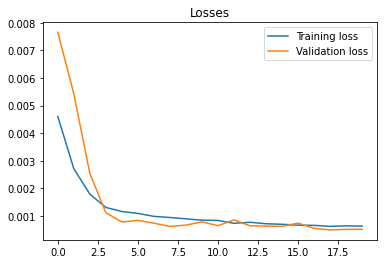

In [ ]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

### Formatting the predictions

As you may recall, we trained our network with standardized inputs; therefore, all the model's predictions are also scaled. Also, after using batching in our evaluation method, all of our predictions are now in batches. To calculate error metrics and plot these predictions, we need first to reduce these multi-dimensional tensors to a one-dimensional vector, i.e., flatten, and then apply inverse_transform() to get the predictions' real values.

In [ ]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Datetime,,
2015-04-10 11:00:00,32296.000000,32963.476562
2015-04-10 12:00:00,31941.000000,32564.544922
2015-04-10 13:00:00,31488.000000,32050.283203
2015-04-10 14:00:00,31067.998047,31640.558594
2015-04-10 15:00:00,30483.000000,31322.837891
...,...,...
2018-08-02 20:00:00,44057.000000,42816.937500
2018-08-02 21:00:00,43256.000000,41400.613281
2018-08-02 22:00:00,41552.000000,40084.664062


### Calculating error metrics

After flattening and de-scaling the values, we can now calculate error metrics, such as mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE).

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(df_result)


Mean Absolute Error:        772.2306
Root Mean Squared Error:    980.3157335777081
R^2 Score:                  0.9771873301517322


### Generating baseline predictions

Having some sort of baseline model helps us compare how our models actually do at prediction. For this task, I've chosen good old linear regression, good enough to generate reasonable baseline but simple enough to do it very fast.

In [ ]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

df_baseline = build_baseline_model(df_timelags, 0.2, 'value')
baseline_metrics = calculate_metrics(df_baseline)


Mean Absolute Error:        202.1403806979192
Root Mean Squared Error:    281.47269392124565
R^2 Score:                  0.9981193123175233


### Visualizing the predictions

Last but not least, visualizing your results helps you better understand how your model performs and adds what kind of features would likely improve it. I'll be using Plotly again, but feel free to use a package that you are more comfortable with.

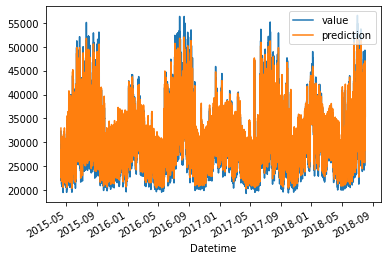

In [ ]:
df_result.plot()